In [1]:
# !curl -L -o ../data/chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

# !unzip ../data/chest-xray-pneumonia.zip -d ../data/
!rm -R ../data/chest_xray//chest_xray/

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))

## Load and Visualize data:


In [25]:
trainImages = tf.keras.utils.image_dataset_from_directory('../data/chest_xray/train')
trainImages.cardinality().numpy() * 32

Found 5216 files belonging to 2 classes.


5216

In [79]:
#load dataset from cell in tfrecord format:
trainImages = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
trainPaths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)


traindataset = tf.data.Dataset.zip((trainImages , trainPaths))

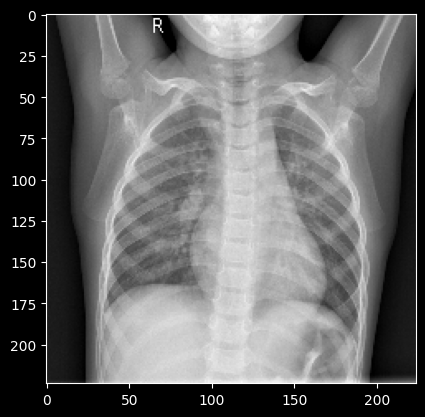

In [80]:
rimage = tf.image.decode_jpeg(raw_img , channels = 3)
# plt.imshow(tf.image.resize(rimage , (224 , 224))/225)
plt.imshow(decode_image(raw_img)/255)

In [81]:
#craete (image , label) pair, the ones you get by default from tf.keras.utils.image_dataset_from_directory()

# for x , y in traindataset.take(1):
#     print(y.numpy().decode('utf-8'))

def get_label(filepath):
    parts = tf.strings.split(filepath , '/')
    return parts[-2] == 'PNEUMONIA'

def decode_image(image):
    image = tf.image.decode_jpeg(image , channels = 3)
    return tf.image.resize(image , (224 , 224))

def processdata(image , filepath):
    label = get_label(filepath)
    image = decode_image(image)
    return (image , label)

traindataset = traindataset.map(processdata , num_parallel_calls= tf.data.AUTOTUNE)

In [82]:
cnormal = len([path for path in trainPaths if 'NORMAL' in path.numpy().decode('utf-8')])
cabnormal = len([path for path in trainPaths if 'PNEUMONIA' in path.numpy().decode('utf-8')])

print(f"Normal Images: {cnormal} , Pneumonia Images: {cabnormal} , total images in training set: {cnormal + cabnormal}")

Normal Images: 1349 , Pneumonia Images: 3883 , total images in training set: 5232


In [83]:
# 0 -> normal
# 1 -> pneumonia
ctotal = cnormal + cabnormal
w0 = (ctotal / (2 * cnormal))
w1 = (ctotal / (2 * cabnormal))
w0 , w1

(1.939214232765011, 0.6737058975019315)

In [84]:
#same thing for testdata:
testImages = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
testpaths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

testdataset = tf.data.Dataset.zip((testImages , testpaths))
testdataset = testdataset.map(processdata , num_parallel_calls= tf.data.AUTOTUNE)

In [ ]:
#tuning for better training:
traindataset = traindataset.batch(32)

In [ ]:
#visualize traindataset:
def show_batch(ibatch , lbatch):
    plt.figure(figsize = (10 , 10))
    for i in range(25):
        plt.subplot(5 , 5, i + 1)
        plt.imshow(ibatch[i] / 255)
        plt.axis('off')

traindataset = traindataset.batch(32)
ibatch , lbatch = next(iter(traindataset))
ibatch.shape
# show_batch(ibatch.numpy() , lbatch.numpy())

In [85]:
images , labels = next(iter(traindataset))

In [88]:
images.numpy().shape

(224, 224, 3)